<img style="float:right;" src="https://data.iflood.vse.gmu.edu/Forecast/ChesapeakeBay_XBEACH/pics_for_deal/labLogoFLOOD_black.png" width=300px>    

# XBeach Post Process


##### Abstract:
Coastal communities along the US mid-Atlantic region have been repeatedly affected by storm surge causing structural damage and flooding. Among different alternatives to prevent damages and flooding due to storm surge, natural and nature-based solutions, such as coastal marshes, are gaining importance as a form of coastal protection. Analysis of the data collected will be applied to coastal numerical models to replicate the nearshore physical processes in coastal marshes. We expect to develop engineering guidelines on the use of this nature based defenses for coastal protection against extreme events.  
<div align="middle">
<img style="float:center;" src="https://data.iflood.vse.gmu.edu/Forecast/ChesapeakeBay_XBEACH/pics_for_deal/Illustration%20of%20Nature%20Conservancy%20project%20site_02.jpg" width=1000px></div>

#### Initialize XBeach Libraries

In [6]:
import sys;sys.path.append('../xbeach/')
from importlib import reload
from libs import *
from scipy.io import loadmat
import xbeach
import utils
from IPython.display import IFrame
import matplotlib as mpl
import oceanwaves as ow
from wave_utils import waves
from xbeach_inputs import *

#### Initialize Paths

In [7]:
root = pl.Path(r'C:\Users\tmiesse\Work\flume')
xb = nc4.Dataset(root / 'rock_sill' / 'rock1' / 'xboutput.nc')

wg = loadmat(root / 'rock_sill' / 'trial_2' / 'wg.mat')

trial = 1
adv1 = loadmat(root / 'rock_sill' / 'rock_adv_u5_cleaned.mat')
adv1_t = adv1['rock5_cleaned'][:,trial]

In [8]:
wg = wg['wg_matrix']
dt = np.arange(0,len(wg),10)
obs_w1 = np.interp(dt,wg[:,0],wg[:,1])

#### Initialize Variables

In [9]:
#x,y = xbeach.utm2geo(xb.variables['globalx'][:,:],xb.variables['globaly'][:,:],code=18,zone='U')
x,y = xb.variables['globalx'][:,:],xb.variables['globaly'][:,:]
z = xb.variables['zb_mean'][:,:,:]
z_no = nc4.Dataset(root / 'rock_sill' / 'trial_1' / 'no_sill' /'xboutput.nc').variables['zb_mean'][:,:,:]

t = xb.variables['meantime'][:]
zs = xb.variables['zs'][:,:,:]
h = xb.variables['H'][:,:,:]
u = xb.variables['u'][:]
v = xb.variables['v'][:]
theta = xb.variables['thet'][:]
x2,y2 = xb.variables['globalx'][:,:],xb.variables['globaly'][:,:]

In [10]:
wave_loc_x = [21.512,24.981,28.737,29.659,31.201,
              32.421,36.156,39.808,43.483,47.133,
              50.795,54.416,58.110,61.561]
wave_loc_y = [-1.371,-1.374,-1.354,-1.345,-1.336,
              -1.332,-1.383,-1.371,-1.374,-1.373,
              -1.363,-1.370,-1.364,-1.367]
ind_x,ind_y= np.zeros(len(wave_loc_x)),np.zeros(len(wave_loc_x))
for i in range(len(wave_loc_x)):
    ind_x[i],ind_y[i] = xbeach.find_node_ak(x,y,wave_loc_y[i],wave_loc_x[i])

#### Show grid and bathy of Study Site

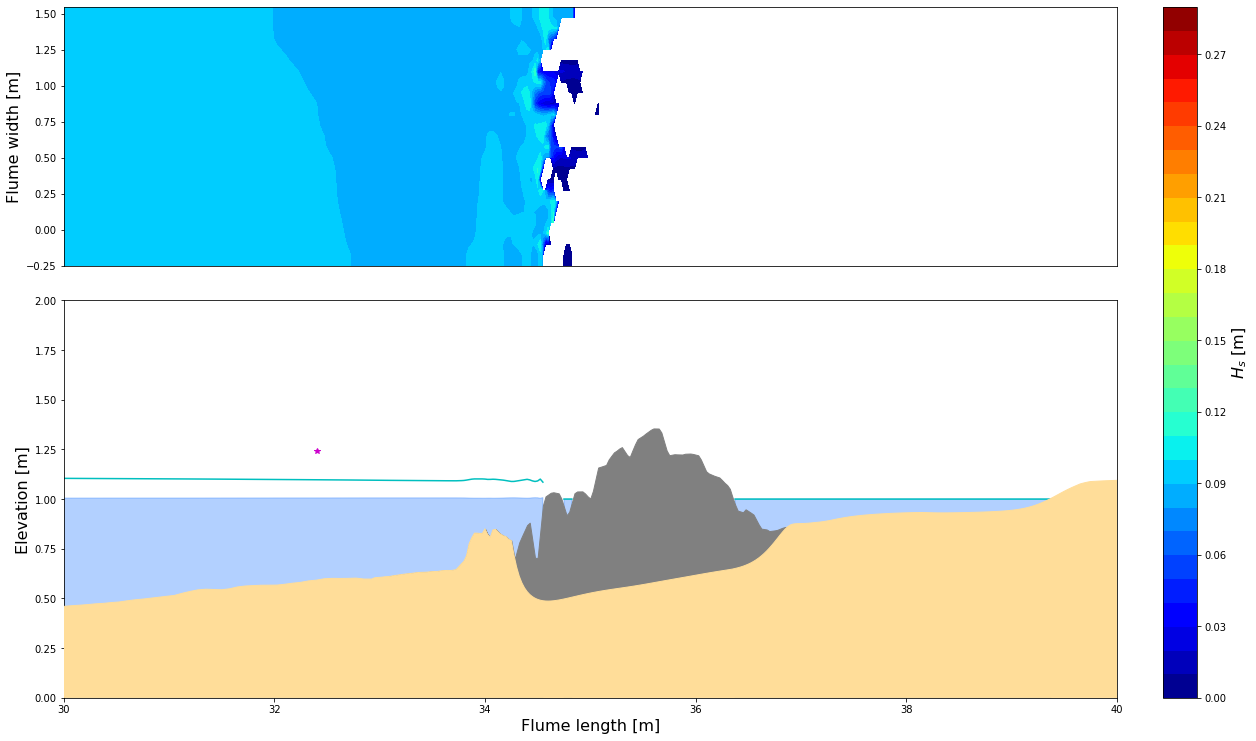

In [14]:
i = 100
space = 0.01
levels = np.arange(0,0.3,space)
fig = plt.figure(figsize=(16,12))
ax1 = plt.axes([0,.5,1,.30])
ax2 = plt.axes([0,0,1,.46])
h[i,:,:][h[i,:,:].mask==True]=h[i,:,:].fill_value
# top contour plot
cont = ax1.contourf(x,y,h[i,:,:],cmap='jet',levels=levels,vmin=np.min(levels),vmax=np.max(levels))

# middle plot
#ax2.plot(x[12,:],z[i,12,:],'k')
ax2.plot(x[int(ind_x[5]),:],zs[i,int(ind_x[5]),:]+h[i,int(ind_x[5]),:],'c')
ax2.plot(x[int(ind_x[5]),int(ind_y[5])],obs_w1[i]+zs[i,int(ind_x[5]),int(ind_y[5])],'*',color='#cc00cc',linewidth=15)
ax2.fill_between(x[int(ind_x[5]),:],zs[i,int(ind_x[5]),:],color='#0066ff',alpha=0.30)
ax2.fill_between(x[int(ind_x[5]),445:598],z[i,int(ind_x[5]),445:598],z_no[0,int(ind_x[5]),445:598],color='grey',zorder=3)
ax2.fill_between(x[int(ind_x[5]),:],z_no[0,int(ind_x[5]),:],0,color='#ffdd99',zorder=3)

#bottom

# aesthetic effects
normalize = mpl.colors.Normalize(vmin=np.min(levels), vmax=np.max(levels))
cb = plt.colorbar(cont,ax=[ax1,ax2],cmap='jet',norm=normalize,fraction=0.046, pad=0.04) 
cb.set_label(r'$H_{s}$ [m]',fontsize=16)
ax1.set_xlim([30,40])
ax2.set_xlim([30,40])
ax1.set_ylabel('Flume width [m]',fontsize=16)
ax2.set_ylim([0,2])
ax1.set_xticks([])

ax2.set_xlabel('Flume length [m]',fontsize=16)
ax2.set_ylabel('Elevation [m]',fontsize=16)

plt.show()

In [11]:
len(h[:,0,0]),len(obs_w1)

(248, 279)

In [13]:
ys,xs = x.shape
sigma =  xb.variables['sigm'][:]
Tp = 1.69
alph = 0.0013
g = 9.81
k_o,freq_o = np.zeros((len(obs_w1))),np.zeros((len(obs_w1)))

In [23]:
wg[4]

array([ 4.00000000e-02, -3.76645150e-04, -2.69519873e-03, -1.71621886e-03,
       -1.00829473e-03,  7.23600785e-04,  7.84538909e-04,  1.82081415e-03,
       -1.16450699e-03,  6.35650953e-06,  1.12494500e-04,  4.09420470e-05,
       -3.82576305e-05,  4.82137047e-05,  7.93178274e-05])

In [32]:
#for i in range(len(obs_w1)):
#k_o = waves.wave_number(g, 1/Tp,0.33)
                      
#freq_o = waves.frequency(g, k_o, 0.33)

spectrum = ow.spectral.jonswap(dt*0+0.01,obs_w1,Tp)

In [33]:
spectrum

array([nan, nan, nan, ..., nan, nan, nan])

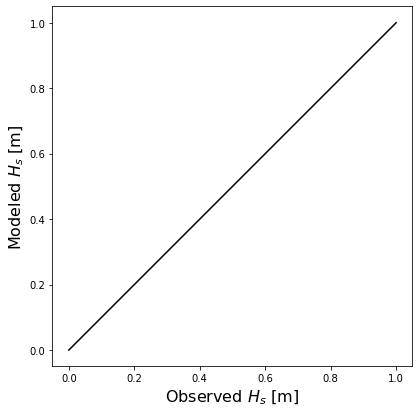

In [30]:
fig = plt.figure(figsize=(5,5))
ax1 = plt.axes([0,0,1,1])


ax1.plot(dt,spectrum,'*',color='#cc00cc',markersize=10)

ax1.plot([0,1],[0,1],'-k')
ax1.set_ylabel(r'Modeled $H_{s}$ [m]',fontsize=16)
ax1.set_xlabel(r'Observed $H_{s}$ [m]',fontsize=16)
#ax1.set_xlim([0,0.4])
#ax1.set_ylim([0,0.4])


plt.show()

In [ ]:
i=100
Tp = (2*np.pi)/sigma[i,:]
